In [1]:
#=
using Pkg
Pkg.add("DataFrame")
=#


In [82]:
using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots, CSV, DataFrames

include("Functions.jl")
#Model\Functions.jl


flux_vec_eq (generic function with 1 method)

In [83]:
@parameters C_ATP C_ADP C_cit C_AMP C_PFKM C_AMPK C_Pi C_G6P C_GAP C_DHAP # Concentrations 
@parameters L_PFKM L_PFK2 # L values
@parameters Vm_GPI Vm_PFK2 Vm_FBP Vm_ALD # V values. Vf are Vmax forward and Vr are Vmax reversed for each enzyme.
@parameters Keq_GPI Keq_PFKM Keq_PFK2 Keq_FBP Keq_ALD # K_eq for each enzyme

@parameters Kf_GPI Kr_GPI # For r_GPI
@parameters Ki_ATP Ki_cit Ka_f6p Ka_f16bp Ka_AMP Ka_f26bp # For N_PFKM Ki is inhibitors and Ka is activators
@parameters Kc_PFKM K_f6p K_ATP K_f16bp K_ADP # For r_PFKM
@parameters Kc_AMPK v_P # For psi
@parameters K2_ATP K2_f6p K2_f26bp K2_ADP # For r_PFK2. 2 refers to PFK2
@parameters K_FBP_f26bp K_FBP_f6p K_Pi # For r_FBP
@parameters KAld_f16bp K_GAP K_DHAP # For r_ALD

@variables t f6p(t) f16bp(t) f26bp(t)
D = Differential(t)

r_GPI = (Vm_GPI/Kf_GPI)*(C_G6P-(f6p/Keq_GPI))/
    (1 + C_G6P/Kf_GPI + f6p/Kr_GPI)
    
N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
    ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

r_PFKM = ((C_PFKM*(Kc_PFKM/(K_f6p*K_ATP))*(C_ATP*f6p - C_ADP*f16bp/Keq_PFKM))/
    ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
    (1/N_PFKM)

psi = (Kc_AMPK*C_AMPK)/((Kc_AMPK*C_AMPK)+v_P)
N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

r_PFK2 = (Vm_PFK2/(K2_ATP*K2_f6p))*((C_ATP*f6p)-(C_ADP*f26bp)/Keq_PFK2)/
    ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
    (1-(1/N_PFK2))

r_FBP = (Vm_FBP/(K_FBP_f26bp))*(f26bp-(f6p*C_Pi)/Keq_FBP)/
    ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
    (1/N_PFK2)

r_ALD = (Vm_ALD/KAld_f16bp)*(f16bp-(C_GAP*C_DHAP)/Keq_ALD)/
    ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

eqs = [D(f6p) ~ r_GPI - r_PFKM - r_PFK2 + r_FBP,
    D(f16bp) ~ r_PFKM - r_ALD,
    D(f26bp) ~ r_PFK2 - r_FBP]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)

Model sys with 3 equations
Unknowns (3):
  f6p(t)
  f16bp(t)
  f26bp(t)
Parameters (46):
  K_f16bp
  Ka_f6p
  K_FBP_f6p
  K_FBP_f26bp
⋮
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

Cons = [C_ATP => rand(Normal(1.85, 1.85*0.5),1)[], #Biochem
    C_ADP => 0.138, #Biochem
    C_cit => 0.1,
    C_AMP => 3*10^-2, #Mulq
    C_PFKM => 4*10^-5,
    C_AMPK => 6.8275*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1, #Biochem + Mulq
    C_G6P => 8.3*10^-2, #Biochem
    C_GAP => 1.9*10^-2, #Biochem 
    C_DHAP => 1.38*10^-1, #Biochem
    ]

In [84]:
# Calculate K_eq 
Keq_GPI1 = (4.8*10^4 * 0.123)/(4.0*10^4 * 0.3)
Keq_PFKM1 = (15.5*10^2 * 0.54 * 0.65)/(6.78*10^1 * 6*10^-2 * 6.8*10^-2)
Keq_PFK21 = 16 
Keq_FBP1 = (11.78 * 25*10^-3 * 0.23)/(1.2 * 1*10^-3)
Keq_ALD1 = (6.75*10^2 * 0.189 * 1.1*10^-2)/(2.32*10^3 * 3.5*10^-2)

# Calculate Kcat_PFKM
Kc_PFKM1 = 15.5*10^2/(4*10^-5)


3.875e7

In [88]:
df_Keq = DataFrame(a=["Keq_GPI1","Keq_PFKM1", "Keq_PFK21", "Keq_FBP1", "Keq_ALD1"], values=[Keq_GPI1, Keq_PFKM1, Keq_PFK21, Keq_FBP1, Keq_ALD1])

Row,a,values
,String,Float64
1,Keq_GPI1,0.492
2,Keq_PFKM1,1966.75
3,Keq_PFK21,16.0
4,Keq_FBP1,56.4458
5,Keq_ALD1,0.0172823


In [79]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]

#=
Random.seed!(1231)
Cons = [C_ATP => rand(LogNormal(-5.643, 0.166),1)[]*1000, #M to mM
    C_ADP => rand(LogNormal(-6.616, 0.169),1)[]*1000, 
    C_cit => rand(LogNormal(-3.930, 0.225),1)[]*1000,
    C_AMP => rand(LogNormal(-12.151, 0.274),1)[]*1000,
    C_PFKM => 4*10^-5,
    C_AMPK => 5.7875*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1, 
    C_G6P => rand(LogNormal(-7.762, 0.314),1)[]*1000, 
    C_GAP => rand(LogNormal(-15.059, 0.165),1)[]*1000, 
    C_DHAP => rand(LogNormal(-13.059, 0.165),1)[]*1000, 
    ]
=#
Cons = [C_ATP => exp(-5.643)*1000, #M to mM
    C_ADP => exp(-6.616)*1000, 
    C_cit => exp(-3.930)*1000,
    C_AMP => exp(-12.151)*1000,
    C_PFKM => 4*10^-5,
    C_AMPK => 5.7875*10^-1, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1, 
    C_G6P => exp(-7.762)*1000, 
    C_GAP => exp(-15.059)*1000, 
    C_DHAP => exp(-13.059)*1000, 
    ]

L = [L_PFKM => 2*10^9,
    L_PFK2 => 1*10^-3]

V = [Vm_GPI => 4.8*10^4,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Vm_ALD => 6.75*10^2]

Keq = [Keq_GPI =>  Keq_GPI1,
    Keq_PFKM => Keq_PFKM1,
    Keq_PFK2 => Keq_PFK21,
    Keq_FBP => Keq_FBP1,
    Keq_ALD => Keq_ALD1]

K = [Kf_GPI => 0.3,
    Kr_GPI => 0.123, #0.123
    Ki_ATP => 0.1,
    Ki_cit => 0.1, #
    Ka_f6p => 6*10^-2,
    Ka_f16bp => 0.35, #0.35 for PFKM and 0.65 for PFKL
    Ka_AMP => 0.3,
    Ka_f26bp => 5.5*10^-8, # 5.5*10^-3
    Kc_PFKM => Kc_PFKM1, # Changed from 15.5*10^2/4*10^-5
    K_f6p => 6*10^-2,
    K_ATP => 6.8*10^-2,
    K_f16bp => 0.65,
    K_ADP => 0.54,
    Kc_AMPK => 0.1, # Check this
    v_P => 0.005, # Check this
    K2_ATP => 0.15,
    K2_f6p => 0.032,
    K2_f26bp => 0.008,
    K2_ADP => 0.062,
    K_FBP_f26bp => 1*10^-3,
    K_FBP_f6p => 25*10^-3,
    K_Pi => 0.23, #
    KAld_f16bp => 5*10^-2,
    K_GAP => 0.189,
    K_DHAP => 3.5*10^-2] 

p= [Cons 
    L 
    V 
    Keq
    K]


46-element Vector{Pair{Num, Float64}}:
       C_ATP => 3.5422257729346014
       C_ADP => 1.3387753510808764
       C_cit => 19.643672553065294
       C_AMP => 0.005283086852082723
      C_PFKM => 4.0e-5
      C_AMPK => 0.57875
        C_Pi => 1.0
       C_G6P => 0.4256045198691194
       C_GAP => 0.00028837618823793605
      C_DHAP => 0.0021308278324858945
             ⋮
      K2_f6p => 0.032
    K2_f26bp => 0.008
      K2_ADP => 0.062
 K_FBP_f26bp => 0.001
   K_FBP_f6p => 0.025
        K_Pi => 0.23
  KAld_f16bp => 0.05000000000000001
       K_GAP => 0.189
      K_DHAP => 0.035

[0.19808384972679446, 0.3398764741291435, 0.02195398620837916]

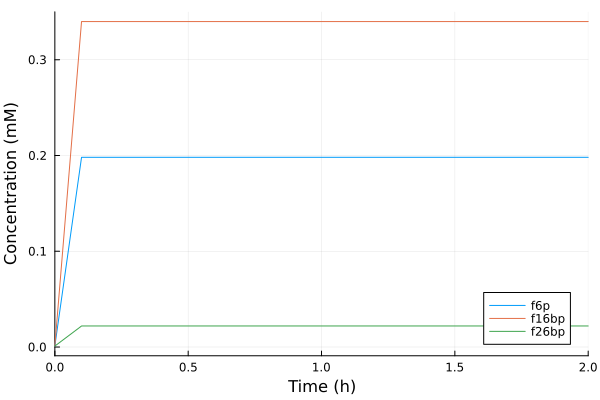

In [80]:
tspan = (0.0, 100)
prob = ODEProblem(sys, u0, tspan, p, jac = true)
sol = solve(prob, Rodas4())
print(sol[end])
ss = sol[end]
plot(sol,
    xlim = (0.0, 2),
    xlabel = "Time (h)",
    ylabel = "Concentration (mM)")


# with u0=[10^-3] [0.017305847888619504, 1.2283514230821401e-5, 0.0003065921332214659]
# with u0=[10^-1] [0.017305847888619504, 1.2283514230821396e-5, 0.0003065921332214658]
# [0.1953610735888062, 0.41939825091612026, 0.0034610362191860545]

In [8]:
#=
df = DataFrame(sol)
CSV.write("out.csv", df)
=#

"out.csv"

In [81]:
#obs_ss = [exp(-7.776), exp(-8.215), exp(-10)]
#flux_vector(obs_ss,p)

# flux_vector(ss, p)
df_eq = flux_vec_eq(ss, p)



1-element Vector{DataFrame}:
 11×2 DataFrame
 Row │ a           values        
     │ String      Float64       
─────┼───────────────────────────
   1 │ r_GPI       913.155
   2 │ r_PFKM      913.155
   3 │ r_PFK2        2.75003
   4 │ r_FBP         2.75003
   5 │ r_ALD       913.155
   6 │ f6p_flux      7.96696e-13
   7 │ f16bp_flux    0.0
   8 │ f26bp_flux   -8.88178e-16
   9 │ psi           0.920477
  10 │ N_PFK2        1.13398
  11 │ N_PFKM        1.25423

In [46]:
SimData(sys, u0, Cons, L, V, K, (0.0,100))
simDat =  SimData(sys, u0, Cons, L, V, K, (0.0,100))
f6p_ss, f16bp_ss, f26bp_ss = simDat[1]
flux_GPI, flux_PFKM, flux_PFK2, flux_FBP, flux_ALD = simDat[2]


6-element Vector{Float64}:
 1139.1784465079074
 1139.1784465079038
    3.871556410533738e-8
    3.871556434090512e-8
 1139.1784465079031
 1549.999999442974

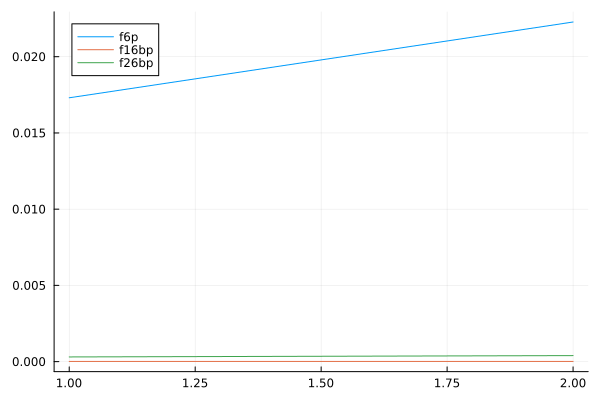

In [17]:
n_sim = 2
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]

f6p_ss_vec = zeros(n_sim);
f16bp_ss_vec = zeros(n_sim);
f26bp_ss_vec = zeros(n_sim);
flux_ss = zeros(5,n_sim);
seed_vec = [1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1230];

for i in 1:n_sim
    Random.seed!(seed_vec[i])
    Cons = [C_ATP => rand(LogNormal(-5.643, 0.166),1)[]*1000, #M to mM
        C_ADP => rand(LogNormal(-6.616, 0.169),1)[]*1000, 
        C_cit => rand(LogNormal(-3.930, 0.225),1)[]*1000,
        C_AMP => rand(LogNormal(-12.151, 0.274),1)[]*1000,
        C_PFKM => 4*10^-5,
        C_AMPK => 5.7875*10^-5, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
        C_Pi => 1, 
        C_G6P => rand(LogNormal(-7.762, 0.314),1)[]*1000, 
        C_GAP => rand(LogNormal(-15.059, 0.165),1)[]*1000, 
        C_DHAP => rand(LogNormal(-13.059, 0.165),1)[]*1000, 
    ]
    simDat = SimData(sys, u0, Cons, L, V, K, (0.0,100))
    f6p_ss_vec[i], f16bp_ss_vec[i], f26bp_ss_vec[i] = simDat[1]
    flux_ss[:,i] = simDat[2]      
end

#print(f6p)
plot([1:n_sim],[f6p_ss_vec,f16bp_ss_vec,f26bp_ss_vec],label=["f6p" "f16bp" "f26bp"])


In [18]:
print(flux_ss[:,1])
0.13 #mmol mLcell^-1 h^-1
0.13*1000 # mmol Lcell^-1 h^-1

[24317.541714676463, 3.2533134625841785e-22, 6.407779754852814e-10, 1.7634508325167237, 12.433016084585603]

130.0